# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [1]:
# Run this to use from colab environment

import zipfile
import os
import pandas as pd
import numpy as np

with zipfile.ZipFile('ecg/ecg_data.zip', 'r') as zip_ref: #TODO: let hierop voor inleveren
    zip_ref.extractall('ecg')

data = pd.read_csv('ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 827
The number of columns: 9001


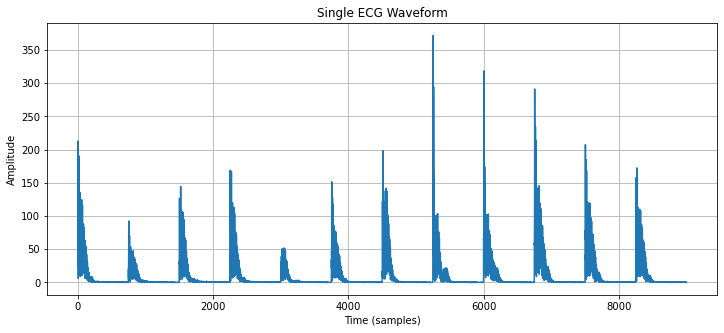

In [2]:
import matplotlib.pyplot as plt

# Select the first row (single ECG waveform)
sample_ecg = data.iloc[0, 1:-1]  # Exclude index and label

# Plot the ECG waveform
plt.figure(figsize=(12, 5))  
plt.plot(sample_ecg.values)  
plt.title('Single ECG Waveform')  
plt.xlabel('Time (samples)')  
plt.ylabel('Amplitude')  
plt.grid(True)  
plt.show()


1. Preprocessing

1.1 Check for missing data

In [3]:
from sklearn.impute import SimpleImputer

def handle_missing_values(data, feature_threshold=0.3, patient_threshold=0.3):
    """
    Handles missing values in the dataset by:
    1. Removing features (columns) with more than a given percentage of missing values.
    2. Removing patients (rows) with more than a given percentage of missing values.
    3. Imputing remaining missing values using the median per feature.
    
    Parameters:
        data (pd.DataFrame): The input dataset.
        feature_threshold (float): Maximum allowed proportion of missing values per feature before removal.
        patient_threshold (float): Maximum allowed proportion of missing values per patient before removal.
    
    Returns:
        pd.DataFrame: Cleaned dataset with missing values handled.
    """

    total_missing = data.isnull().sum().sum()
    print(f"Total missing values: {total_missing}")

    if total_missing == 0:
        return data

    print("Handling missing values...")

    # Define absolute thresholds based on proportions
    feature_missing_threshold = feature_threshold * len(data)  
    patient_missing_threshold = patient_threshold * len(data.columns)  

    # Step 1: Remove features with more than the allowed missing value percentage
    features_to_drop = data.columns[data.isnull().sum() > feature_missing_threshold]
    if len(features_to_drop) > 0:
        data = data.drop(columns=features_to_drop)
        print(f"Dropped features due to excessive missing values: {list(features_to_drop)}")

    # Step 2: Remove patients with more than the allowed missing value percentage
    patients_to_drop = data.index[data.isnull().sum(axis=1) > patient_missing_threshold]
    if len(patients_to_drop) > 0:
        data = data.drop(index=patients_to_drop)
        print(f"Dropped {len(patients_to_drop)} patients due to excessive missing values.")

    # Step 3: Impute remaining missing values using median per feature
    imputer = SimpleImputer(strategy='median')
    data[:] = imputer.fit_transform(data)
    print("Applied median imputation to remaining missing values.")

    return data

data_cleaned = handle_missing_values(data)

Total missing values: 0


1.2 Outliers (denk dat wij dit niet gaan/moeten toepassen)

In [4]:
def remove_outliers_zscore(data, threshold=4):
    """
    Removes rows containing features with Z-score greater than the threshold.
    Parameters:
        data (pd.DataFrame): The input dataset.
        threshold (float): The Z-score threshold for identifying outliers.
    Returns:
        pd.DataFrame: DataFrame with outliers removed.
    """
    # Compute the Z-scores
    z_scores = (data - data.mean()) / data.std()
    
    # Identify rows where any feature has a Z-score above the threshold
    outliers = (np.abs(z_scores) > threshold).any(axis=1)
    
    # Remove outliers
    data_cleaned = data[~outliers]
    
    print(f"Data shape before removing outliers: {data.shape}")
    print(f"Data shape after removing outliers: {data_cleaned.shape}")
    
    return data_cleaned

# Apply the function to your dataset
data_cleaned = remove_outliers_zscore(data)

Data shape before removing outliers: (827, 9001)
Data shape after removing outliers: (426, 9001)


1.3 Standardization (niet nodig als we Random Forest/XGBoost gebruiken)

In [5]:
from sklearn.preprocessing import StandardScaler

# Initialiseer de scaler
scaler = StandardScaler()

# Pas de transformatie toe op alle numerieke features
X_scaled = scaler.fit_transform(X) # mean 0 and sd 1

NameError: name 'X' is not defined

1.4 Split into train, test and validation set

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# Splits features en labels
X = data.iloc[:, :-1].values  # Alle kolommen behalve de laatste zijn de features
y = data.iloc[:, -1].values   # De laatste kolom is de label (0 of 1)

# Stap 1: Split the dataset in 80% training and 20% testset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Stap 2: Splits de trainingsset verder in 80% train en 20% validatieset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Stap 3: Stratified K-Fold Cross-Validation (k=5)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Voorbeeld van hoe je de gesplitste data door de cross-validation heen zou kunnen laten lopen
#for train_idx, val_idx in kf.split(X_train, y_train):
#    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
#    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
#    print(f"Training fold size: {len(X_train_fold)}, Validation fold size: {len(X_val_fold)}")


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Loading ECG data and seperating labels & features
df = pd.read_csv("ecg/ecg_data.csv")
df = df.drop(columns=['Unnamed: 0'])  # Drop index column if exists
X = df.drop(columns=['label'])
y = df['label']

# Select low-frequency features: first 100 bins from each lead
low_freq_features = [col for col in X.columns if int(col.split('_')[1]) < 100]
X_low_freq = X[low_freq_features]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_low_freq)

# Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest with class balancing
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  
)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.91       137
           1       0.67      0.07      0.12        29

    accuracy                           0.83       166
   macro avg       0.75      0.53      0.52       166
weighted avg       0.81      0.83      0.77       166


Confusion Matrix:
[[136   1]
 [ 27   2]]

ROC AUC Score: 0.7021142713314875


C:\Users\aryav\AppData\Local\Temp\ipykernel_2952\4263133726.py:22: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\aryav\AppData\Local\Temp\ipykernel_2952\4263133726.py:22: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\aryav\AppData\Local\Temp\ipykernel_2952\4263133726.py:22: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\aryav\AppData\Local\Temp\ipykernel_2952\4263133726.py:22: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated 

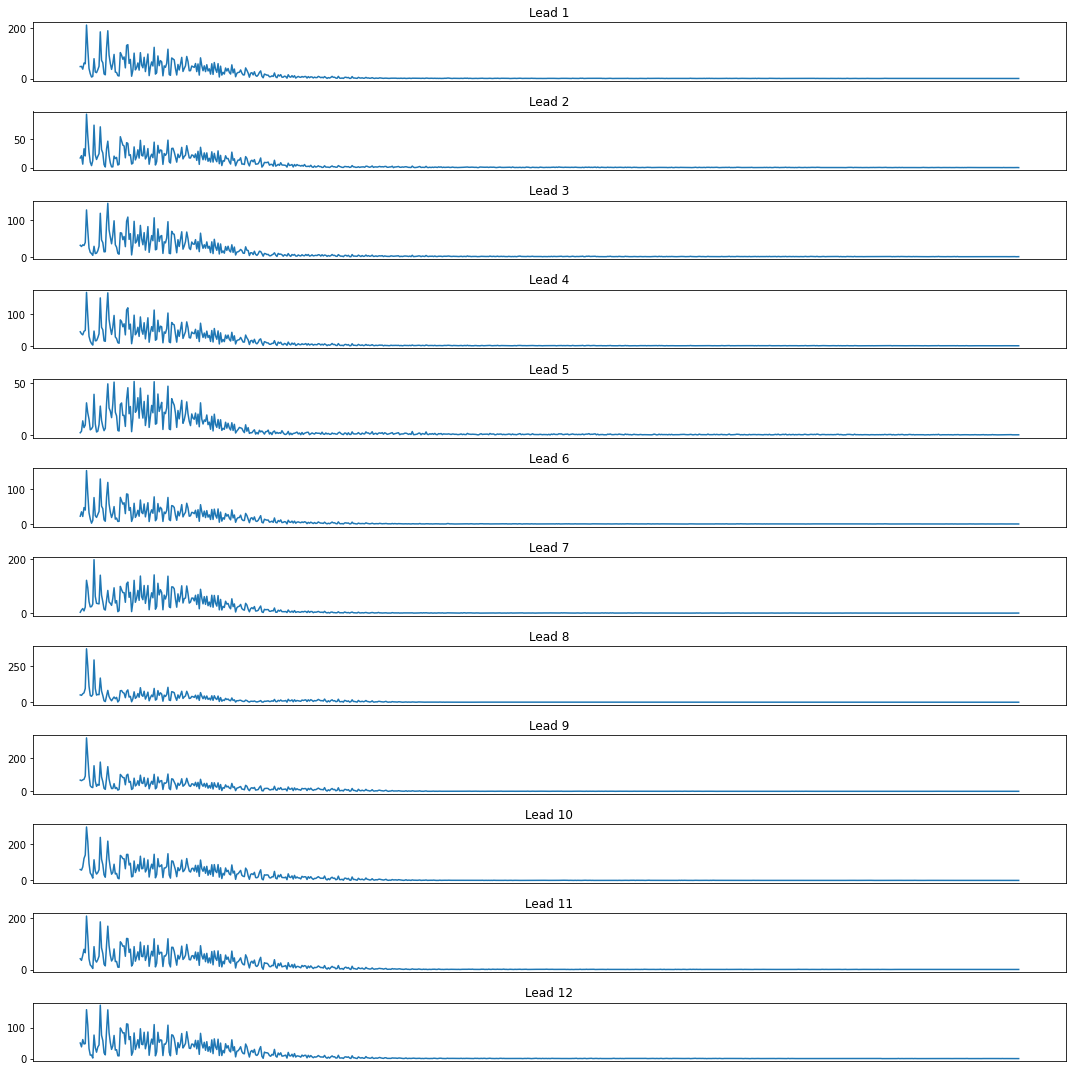

In [ ]:
import matplotlib.pyplot as plt

# Select the first row (single ECG waveform)
sample_ecg = data.iloc[0, :-1]  # Exclude index and label

num_leads = 12
lead_size = 750

fig, axes = plt.subplots(num_leads, 1, figsize=(15, 15))
axes = axes.flatten()

# Loop through each lead
for i, ax in enumerate(axes):
    lead_start = i * lead_size       # Calculate the start index of the lead
    lead_end = (i + 1) * lead_size  # Calculate the end index of the lead
    lead = sample_ecg[lead_start:lead_end]  # Extract the lead data

    ax.plot(lead)  # Plot the lead
    ax.set_title(f'Lead {i+1}')  # Add title

    # Remove x-axis ticks and labels
    ax.set_xticks([])
    ax.set_xticklabels([])

plt.tight_layout()  # Adjust the subplots to fit into the figure
plt.show()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'kernel': 'rbf', 'gamma': 0.01, 'C': 1}
Best ROC AUC (CV): 0.8115607779698326

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       137
           1       0.32      0.41      0.36        29

    accuracy                           0.75       166
   macro avg       0.60      0.62      0.60       166
weighted avg       0.77      0.75      0.76       166

Confusion Matrix:
[[112  25]
 [ 17  12]]
ROC AUC Score: 0.7123080795368739


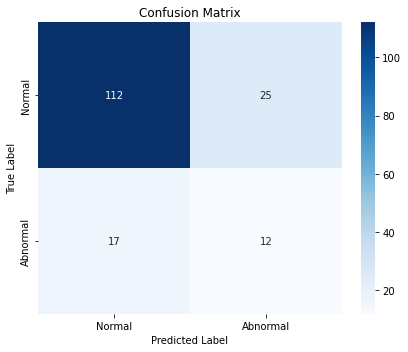

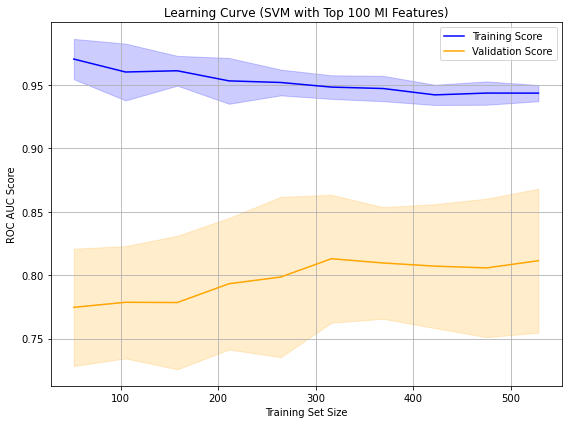

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import mutual_info_classif
import numpy as np

df = pd.read_csv("ecg/ecg_data.csv")
df = df.drop(columns=["Unnamed: 0"], errors="ignore")
X = df.drop(columns=["label"])
y = df["label"]


# low_freq_features = [col for col in X.columns if int(col.split('_')[1]) < 100]
# X = X[low_freq_features]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mi_scores = mutual_info_classif(X_train_scaled, y_train)
mi_feature_indices = np.argsort(mi_scores)[-100:]  # Select top 100 features
X_train_mi = X_train_scaled[:, mi_feature_indices]
X_val_mi = X_test_scaled[:, mi_feature_indices]

param_distributions = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Randomized search
random = RandomizedSearchCV(
    estimator=SVC(probability=True, class_weight='balanced'),
    param_distributions=param_distributions,  # ✅ correct key here
    scoring='roc_auc',
    n_iter=10,  # How many random combinations to try
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random.fit(X_train_mi, y_train)

best_svm = random.best_estimator_
print("Best Parameters:", random.best_params_)
print("Best ROC AUC (CV):", random.best_score_)

y_pred = best_svm.predict(X_val_mi)
y_prob = best_svm.predict_proba(X_val_mi)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
labels = ['Normal', 'Abnormal']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# --- Learning Curve ---
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_svm,
    X=X_train_mi,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(train_sizes, val_mean, label="Validation Score", color="orange")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="orange")
plt.title("Learning Curve (SVM with Top 100 MI Features)")
plt.xlabel("Training Set Size")
plt.ylabel("ROC AUC Score")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


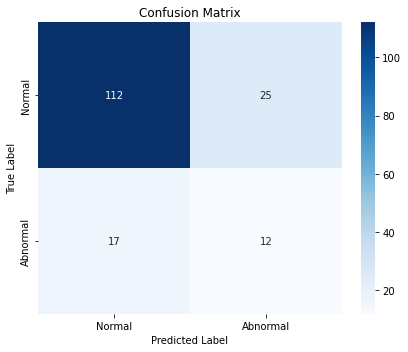

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Normal', 'Abnormal']

# Plot with seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
